Text(0, 0.5, 'y')

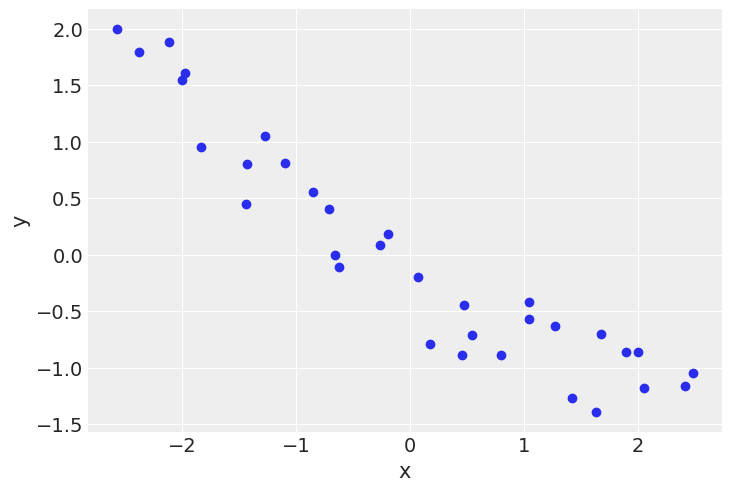

In [66]:
import pymc as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import arviz as az

az.style.use('arviz-darkgrid')
dummy_data = np.loadtxt('date.csv')
x_1 = dummy_data[:, 0]
y_1 = dummy_data[:, 1]

order = 3

x_1p = np.vstack([x_1**i for i in range(1, order+1)])
x_1s = (x_1p - x_1p.mean(axis=1, keepdims=True))
x_1p.std(axis=1, keepdims=True)
y_1s = (y_1 - y_1.mean()) / y_1.std()

plt.scatter(x_1s[0], y_1s)
plt.xlabel('x')
plt.ylabel('y')

In [67]:
# 1 a)
with pm.Model() as model_l:
    alpha = pm.Normal("alpha", 0, 1)
    beta = pm.Normal("beta", 0, 10)
    sigma = pm.HalfNormal("ε", 5)

    mu = alpha + beta * x_1s[0]
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y_1s)

    idata_l = pm.sample(2000, return_inferencedata=True, idata_kwargs={"log_likelihood": True}
)


with pm.Model() as model_p:
    alpha = pm.Normal("alpha", 0, 1)
    beta = pm.Normal("beta", 0, 10, shape=order)
    sigma = pm.HalfNormal("ε", 5)

    mu = alpha + pm.math.flatten(pm.math.dot(beta, x_1s))
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y_1s)

    idata_p = pm.sample(2000, return_inferencedata=True, idata_kwargs={"log_likelihood": True}
)


# 1 b)
with pm.Model() as model_p_wide:
    alpha = pm.Normal("alpha", 0, 1)
    beta = pm.Normal("beta", 0, 100, shape=order)
    sigma = pm.HalfNormal("ε", 5)

    mu = alpha + pm.math.flatten(pm.math.dot(beta, x_1s))
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y_1s)

    idata_p_wide = pm.sample(2000, return_inferencedata=True, idata_kwargs={"log_likelihood": True}
)


sd_vec = np.array([10, 0.1, 0.1])

with pm.Model() as model_p_shrink:
    alpha = pm.Normal("alpha", 0, 1)
    beta = pm.Normal("beta", 0, sd_vec, shape=order)
    sigma = pm.HalfNormal("ε", 5)

    mu = alpha + pm.math.flatten(pm.math.dot(beta, x_1s))
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y_1s)

    idata_p_shrink = pm.sample(2000, return_inferencedata=True, idata_kwargs={"log_likelihood": True}
)



Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, ε]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, ε]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, ε]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, ε]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


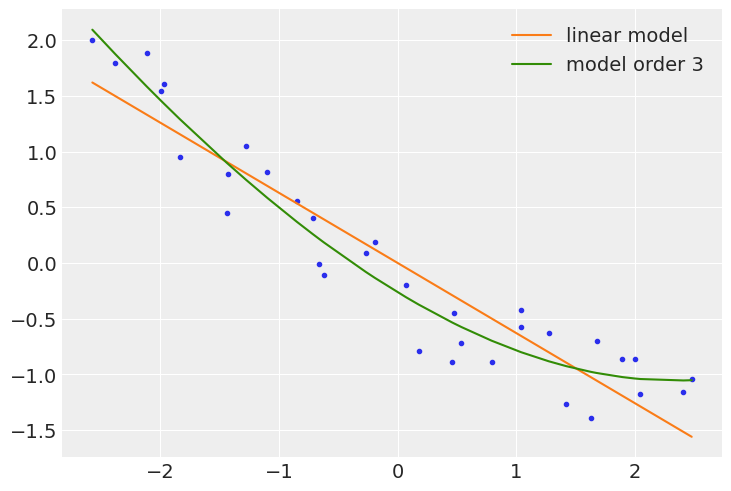

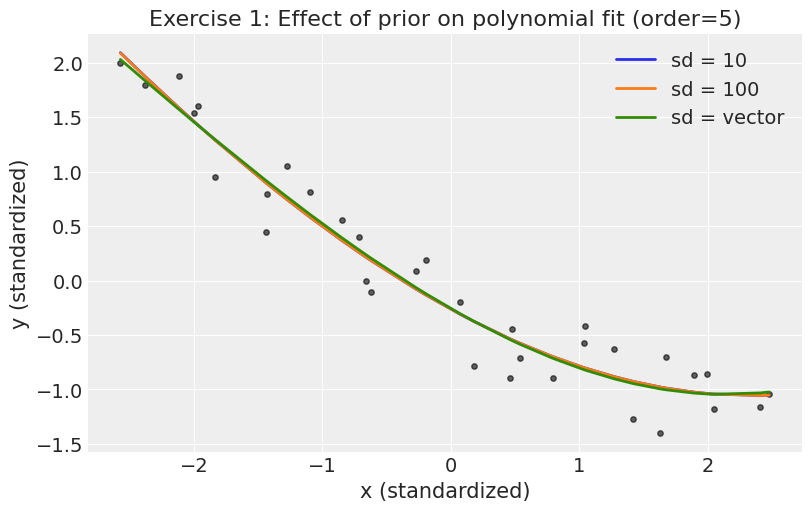

In [68]:
def posterior_curve(idata, x_basis):
    alpha = idata.posterior['alpha'].mean(("chain", "draw")).values
    beta = idata.posterior['beta'].mean(("chain", "draw")).values
    return alpha + np.dot(beta, x_basis)


x_new = np.linspace(x_1s[0].min(), x_1s[0].max(), 100)
alpha_l_post = idata_l.posterior['alpha'].mean(("chain", "draw")).values
beta_l_post = idata_l.posterior['beta'].mean(("chain", "draw")).values
y_l_post =alpha_l_post + beta_l_post * x_new

plt.plot(x_new, y_l_post, 'C1', label='linear model')

alpha_p_post = idata_p.posterior['alpha'].mean(("chain", "draw")).values
beta_p_post = idata_p.posterior['beta'].mean(("chain", "draw")).values
idx = np.argsort(x_1s[0])
y_p_post = alpha_p_post + np.dot(beta_p_post, x_1s)

plt.plot(x_1s[0][idx], y_p_post[idx], 'C2', label=f'model order {order}')
plt.scatter(x_1s[0], y_1s, c='C0', marker='.')
plt.legend()

plt.figure(figsize=(8, 5))

idx = np.argsort(x_1s[0])

# sd = 10
y_sd10 = posterior_curve(idata_p, x_1s)
plt.plot(x_1s[0][idx], y_sd10[idx], label='sd = 10', lw=2)

# sd = 100
y_sd100 = posterior_curve(idata_p_wide, x_1s)
plt.plot(x_1s[0][idx], y_sd100[idx], label='sd = 100', lw=2)

# heterogeneous sd
y_shrink = posterior_curve(idata_p_shrink, x_1s)
plt.plot(x_1s[0][idx], y_shrink[idx], label='sd = vector', lw=2)

# data
plt.scatter(x_1s[0], y_1s, c='black', s=15, alpha=0.6)

plt.xlabel("x (standardized)")
plt.ylabel("y (standardized)")
plt.title("Exercise 1: Effect of prior on polynomial fit (order=5)")
plt.legend()
plt.show()



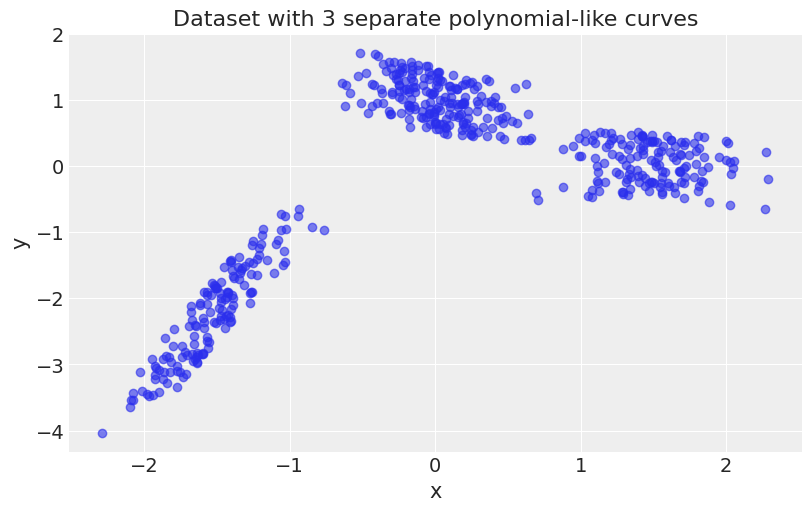

In [69]:
#For ex 2

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

n_total = 500
n_clusters = 3  # 3 separate curves

# Number of points per cluster
cluster_sizes = [150, 200, 150]

# Cluster centers for x
x_centers = [-1.5, 0, 1.5]

# Different polynomials for each cluster
polynomials = [
    [0.5, 1.0, -0.5],  # cluster 1: y = 0.5 + 1*x - 0.5*x^2
    [1.0, -0.5, 0.2],  # cluster 2
    [-0.5, 0.8, -0.3]  # cluster 3
]

x_list = []
y_list = []

for c, s, coeffs in zip(x_centers, cluster_sizes, polynomials):
    # Generate x around cluster center
    x = np.random.normal(loc=c, scale=0.3, size=s)
    # Compute polynomial y = a + b*x + c*x^2
    y = coeffs[0] + coeffs[1]*x + coeffs[2]*x**2
    # Add some noise
    y += np.random.uniform(-0.5, 0.5, size=s)
    
    x_list.append(x)
    y_list.append(y)

# Combine all clusters
x_total = np.hstack(x_list)
y_total = np.hstack(y_list)

# Shuffle points
indices = np.arange(len(x_total))
np.random.shuffle(indices)
x_total = x_total[indices]
y_total = y_total[indices]

# Save
np.savetxt("date_500.csv", np.column_stack([x_total, y_total]))

# Plot to visualize
plt.figure(figsize=(8,5))
plt.scatter(x_total, y_total, alpha=0.6)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Dataset with 3 separate polynomial-like curves")
plt.show()


In [70]:
order_cubic = 3

x_1p3 = np.vstack([x_1**i for i in range(1, order_cubic + 1)])
x_1s3 = x_1p3 - x_1p3.mean(axis=1, keepdims=True)
x_1s3 /= x_1p3.std(axis=1, keepdims=True)


with pm.Model() as model_cubic:
    alpha = pm.Normal("alpha", 0, 1)
    beta = pm.Normal("beta", 0, 10, shape=3)
    sigma = pm.HalfNormal("ε", 5)

    mu = alpha + pm.math.flatten(pm.math.dot(beta, x_1s3))
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y_1s)

    idata_cubic = pm.sample(
        2000,
        return_inferencedata=True,
        idata_kwargs={"log_likelihood": True}
    )



Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, ε]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


In [71]:
idata_dict = {
    "linear": idata_l,
    "quadratic": idata_p,
    "cubic": idata_cubic
}



In [72]:
waic_cmp = az.compare(idata_dict, ic="waic")
waic_cmp


,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
cubic,0,-5.479612,3.310617,0.000000,1.000000e+00,2.308576,0.000000,False,log
quadratic,1,-5.527419,3.376722,0.047807,1.110223e-16,2.317133,0.056397,False,log
linear,2,-14.389075,2.466903,8.909463,0.000000e+00,2.663759,2.660161,False,log


In [73]:
loo_cmp = az.compare(idata_dict, ic="loo")
loo_cmp


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
cubic,0,-5.538963,3.369968,0.000000,1.000000e+00,2.313064,0.000000,False,log
quadratic,1,-5.608209,3.457512,0.069246,1.471046e-15,2.321483,0.067832,False,log
linear,2,-14.418856,2.496683,8.879893,0.000000e+00,2.669652,2.664923,False,log


In [76]:
def posterior_mean_curve(idata, x_basis):
    alpha = idata.posterior["alpha"].mean(("chain", "draw")).values
    beta = idata.posterior["beta"].mean(("chain", "draw")).values
    return alpha + beta @ x_basis


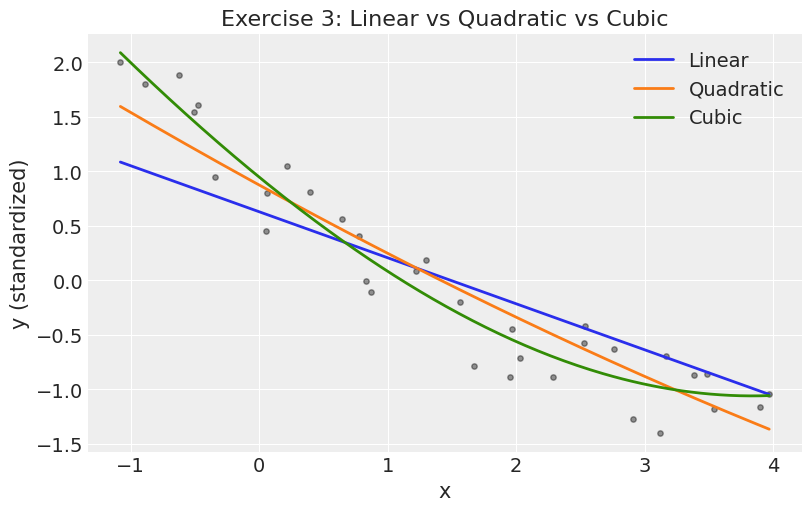

In [77]:
x_plot = np.linspace(x_1.min(), x_1.max(), 200)

def standardize_basis(x, order, mean, std):
    xp = np.vstack([x**i for i in range(1, order + 1)])
    return (xp - mean) / std

plt.figure(figsize=(8, 5))

# ---------- Linear ----------
alpha_l = idata_l.posterior["alpha"].mean(("chain","draw")).values
beta_l = idata_l.posterior["beta"].mean(("chain","draw")).values

x_lin = x_1s[0].mean() + (x_plot - x_1.mean()) / x_1.std()
y_lin = alpha_l + beta_l * x_lin

plt.plot(x_plot, y_lin, label="Linear", lw=2)

# ---------- Quadratic ----------
alpha_q = idata_p.posterior["alpha"].mean(("chain","draw")).values
beta_q = idata_p.posterior["beta"].mean(("chain","draw")).values

x_quad = standardize_basis(
    x_plot,
    order=3,
    mean=x_1p.mean(axis=1, keepdims=True),
    std=x_1p.std(axis=1, keepdims=True),
)

y_quad = alpha_q + beta_q @ x_quad
plt.plot(x_plot, y_quad, label="Quadratic", lw=2)

# ---------- Cubic ----------
alpha_c = idata_cubic.posterior["alpha"].mean(("chain","draw")).values
beta_c = idata_cubic.posterior["beta"].mean(("chain","draw")).values

x_cubic = standardize_basis(
    x_plot,
    order=3,
    mean=x_1p3.mean(axis=1, keepdims=True),
    std=x_1p3.std(axis=1, keepdims=True),
)

y_cub = alpha_c + beta_c @ x_cubic
plt.plot(x_plot, y_cub, label="Cubic", lw=2)

# ---------- Data ----------
plt.scatter(x_1, y_1s, s=15, alpha=0.4, color="black")

plt.xlabel("x")
plt.ylabel("y (standardized)")
plt.title("Exercise 3: Linear vs Quadratic vs Cubic")
plt.legend()
plt.show()
